In [1]:
%reload_ext autoreload
#!pip install -r requirements.txt
!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu
  Using cached https://download.pytorch.org/whl/nightly/cpu/torchaudio-0.14.0.dev20221116-cp39-cp39-macosx_12_0_arm64.whl (3.4 MB)

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
%autoreload
from architectures.RGAN import RGAN
from utils import *
from trainers import *
import numpy as np
np.random.seed(42)

trainset = TimeGANDatasetSinus(num=16, seq_len=100, alpha=0.7, noise=0)
testset = TimeGANDatasetSinus(num=300, seq_len=100, alpha=0.7, noise=0)
print(len(trainset))
print(trainset[0][0].size())


16
torch.Size([100, 3])


In [5]:
%autoreload
import neptune.new as neptune
import torch

run = neptune.init_run(
    project="kohmann/timeGAN",
    name="rgan",
    tags=["rgan"],
    description="RGAN",
    source_files=["rgan.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)


device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "model_name": "model_rgan.pt",
    "n_epochs": 400,
    "l_rate": 0.0001,
    "batch_size": 16,
    "num_layers": 2,
    "hidden_dim": 20,
    "Z_dim": 100,
    "dis_thresh": 0.15,
    "dataset": "sinus",
    "padding_value": 0.,
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
    "optimizer": "Adam",
}
run["parameters"] = params

model = RGAN(params)

rgan_trainer(model,
                trainset,
                batch_size=params["batch_size"],
                device=torch.device(params["device"]),
                learning_rate=params["l_rate"],
                n_epochs=params["n_epochs"],
                max_seq_len=params["max_seq_len"],
                dis_thresh=params["dis_thresh"],
                neptune_logger=run,
                model_name=params["model_name"]
                )
# Generate random synthetic data
gen_z = rgan_generator(model, torch.tensor(testset.T), params["model_name"], torch.device(device), testset[0][0].size(0), 100)

log_visualizations(testset, gen_z, run) # logs pca, tsne, umap, mode_collapse
run["model_checkpoint"].upload(params["model_name"])

run.stop()

https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-155
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.

Start Training


Epoch: 0, G: nan, D: nan:   0%|          | 1/400 [00:04<27:11,  4.09s/it]Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute train/Joint/Generator
Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute train/Joint/Discriminator
Epoch: 1, G: nan, D: nan:   0%|          | 2/400 [00:09<30:33,  4.61s/it]


KeyboardInterrupt: 

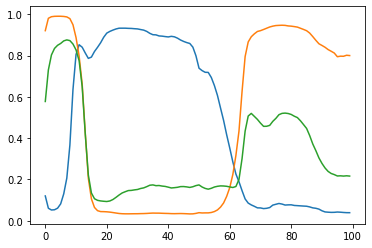

In [10]:
plt.plot(gen_z[2]);

In [5]:
def create_sin3(sin1, sin2, temporal=False):
    sin1, sin2 = np.array(sin1), np.array(sin2)
    e = 0.7  # temporal information weight
    seq_len = len(sin1)
    importance = np.array([e ** i for i in range(seq_len)])

    if temporal:
        sin3 = []
        for i in range(1, seq_len + 1):
            sin3.append(((importance[:i][::-1] * sin1[:i] + importance[:i][::-1] * sin2[:i]) / 2).sum())
        return sin3
    else:
        return [(s1 + s2) / 2 for s1, s2 in zip(sin1, sin2)]

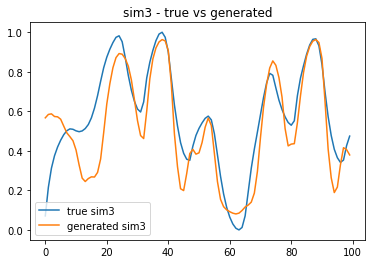

In [6]:
sample = 6
real_combo = create_sin3(gen_z[sample][:,0], gen_z[sample][:,1], temporal=True)
real_comb_scaled = minmaxscaler().fit_transform(torch.tensor([real_combo]))[0]
gen_combo = gen_z[sample][:,2]
plt.plot(real_comb_scaled, label="true sim3")
plt.plot(gen_combo, label="generated sim3")
plt.title("sim3 - true vs generated")
plt.legend()